In [186]:
from matplotlib import image
import math
import matplotlib.pyplot as plt
import requests
import random
import numpy as np
import numpy.linalg as lin
import scipy.special as ss

# Convert binary text into a list
def convert_to_list(raw_img):
  converted_list = []
  temp_row = []
  for i in raw_img:
    if(i != '\n'):
      if(i == '0'):
        temp_row.append(0)
      else:
        temp_row.append(1)
    else:
      converted_list.append(temp_row)
      temp_row = []

  return converted_list

###############################################
# Displaying listed data as images
###############################################
def display_img(img_data):
  plt.imshow(img_data, cmap='Greys',  interpolation='nearest')
  plt.axis('off')
  return

###############################################
# Adding noise to the system
###############################################
def add_noise(data,noise_prob):

  # Initialize noisy data
  noisy_data = []

  # Sanity checker
  if(noise_prob < 0 or noise_prob > 1):
    print("Error! Noise probability isn't correct")
    return

  # Get total length per row
  col_length = len(data[0])

  # Generate fixed length
  shuffle_list = [x for x in range(col_length)]
  cutoff_idx = round(col_length * noise_prob)

  # Iterate per row
  for row in data:

    # Do random indexing
    random.shuffle(shuffle_list)
    temp_row = []

    # Start flipping bits
    for i in range(col_length):
      if(shuffle_list[i] < cutoff_idx):
        if(row[i] == 0):
          temp_row.append(1)
        else:
          temp_row.append(0)
      else:
        temp_row.append(row[i])

    noisy_data.append(temp_row)

  return noisy_data

###############################################
# This just displays a clean set of letters
###############################################
def show_set(clean_letters):

  fig, axs = plt.subplots(6, 5, figsize=(20, 20))

  counter = 0
  for i in range(5):
    for j in range(5):
      axs[i,j].imshow(1-np.reshape(clean_letters[i*5+j],(7,5)), cmap='Greys',  interpolation='nearest')

  axs[5,0].axis('off')
  axs[5,1].axis('off')

  axs[5,2].imshow(1-np.reshape(clean_letters[25],(7,5)), cmap='Greys',  interpolation='nearest')

  axs[5,3].axis('off')
  axs[5,4].axis('off')

  plt.show()

###############################################
# Displays a single letter
###############################################
def show_letter(letter):
  plt.imshow(1-np.reshape(letter,(7,5)), cmap='Greys',  interpolation='nearest')

###############################################
# Magnitude counter
###############################################
def get_mag(A):
  return np.sum(A)

###############################################
# Importing data
###############################################
# This data set contains all the letter from A to Z
# Each row is a vectorized version of the letter
# Each letter image has 7x5 pixel dimensions
# The data set is arranged such that A is the first row and Z is the last
# We made them into arrays too for simplicity
clean_letters = convert_to_list(list(requests.get('https://raw.githubusercontent.com/rgantonio/CoE161---FileDump/main/letters.txt').text))
clean_letters = np.array(clean_letters)


[0 1 1 1 0 1 0 0 0 1 1 0 0 0 1 1 0 0 0 1 1 0 0 0 1 1 0 0 0 1 0 1 1 1 0]


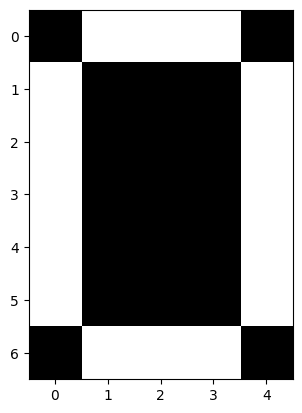

In [187]:
###############################################
# Randomly display a single letter one at a time
###############################################
i = random.randint(0, 25)
show_letter(clean_letters[i])
print(clean_letters[i])

In [188]:
###############################################
# Set parameters
###############################################
D = 2048
M = 20    # Number of ones
print("Density: " + str(M/D))

Density: 0.009765625


In [189]:
# Generate random HV, with 10% ones
def u_gen_rand_hv(D):

    # Sanity checker
    if (D % 2):
        print("Error - D can't be an odd number")
        return 0

    hv = np.zeros(D, dtype = int)
    indices = np.random.permutation(D)

    hv[indices >= M] = 0
    hv[indices < M] = 1

    return hv

In [190]:
def countones(A):
  cnt1 = 0
  for i in A:
    if (i == 1):
      cnt1 += 1
  return (cnt1/len(A))

In [191]:
###############################################
# Overlap calculation
###############################################
def overlap(A,B,D):
    return np.sum(np.logical_and(A,B))/D

In [192]:
def perm(A,N):
  return np.roll(A,N)

In [193]:
def superimpose(block):
  # Apply OR to all HV's in block
  return np.array([1 if x >= 1 else 0 for x in sum(block)])

In [194]:
# def CDT(A,K):
#   # Returns thinned vector, K controls the density (K=1 in original paper)
#   thinned_list = []
#   for k in range(1,K+1):
#     el = np.logical_and(A,perm(A,k))
#     thinned_list.append(el)
#   # OR together the shifted vectors
#   return np.array([1 if x >= 1 else 0 for x in sum(thinned_list)])

In [195]:
# def HGN(block):
  # return CDT(superimpose(block),1)

In [196]:
def HGN2(block):
  # Alternative? implementation, maintaining a lower density
  # Results are worse and much more inconsistent
  K = 1
  # Returns thinned vector, K controls the density (K=1 in original paper)
  thinned_list = []
  or_list = []
  for k in range(1,K+1):
    for j in range(0,len(block)):
      el = np.logical_and(block[j],perm(block[j],k))
      thinned_list.append(el)
    or_list.append(np.array([1 if x >= 1 else 0 for x in sum(thinned_list)]))
  # OR together the shifted vectors
  return superimpose(or_list)

In [197]:
def HGN(block):
  # implementation as in the paper (additive CDT)
  K = 1
  thinned_list = []
  Z = superimpose(block)
  # print(countones(Z))
  for k in range(1,K+1):
    thinned_list.append(np.logical_and(Z, perm(Z,k)))
  
  # X = superimpose(thinned_list)
  # thinned_list = []
  # for k in range(1,K+1):
  #   thinned_list.append(np.logical_and(X, perm(X,k)))

  # X = superimpose(thinned_list)
  # thinned_list = []
  # for k in range(1,K+1):
  #   thinned_list.append(np.logical_and(X, perm(X,k)))
  
  encoded = superimpose(thinned_list)
  # print(countones(encoded))
  return encoded

In [198]:
# Sandbox
A = u_gen_rand_hv(D)
B = u_gen_rand_hv(D)
C = u_gen_rand_hv(D)
E = u_gen_rand_hv(D)

# Create HV block and bundle
print(countones(A))
block_test = np.array([A,B,C,E])
print(block_test)
test = HGN(block_test)
print(test)
# print(overlap(A,A,D))
print(countones(test))
print(countones(superimpose(block_test)))

0.009765625
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[0 0 0 ... 0 0 0]
0.0009765625
0.0380859375


# **Encoding**

In [199]:
def create_item_mem(N,D):
  item_mem = dict()
  for n in range(N):
    item_mem[n] = u_gen_rand_hv(D)
  return item_mem

In [200]:
# Initialize item memory
letter_im = create_item_mem(35,D)
# print(letter_im)

In [201]:
# HDC encoder
def hdc_encode(letter, letter_im, D):
  letter_block = []
  for i in range(len(letter)):
    if(letter[i] == 1):
      hv = perm(letter_im[i],1)
    else:
      hv = letter_im[i]

    letter_block.append(hv)
    # print(countones(superimpose(letter_block)))
  return HGN(letter_block)

In [202]:
###############################################
# Checker. Go ahead and change the index of the clean_letters
###############################################
check_hdc_encode = hdc_encode(clean_letters[2],letter_im,D)
print(check_hdc_encode)
nbones = 0
for i in check_hdc_encode:
  if (i==1): nbones += 1
print(nbones)
print("Density: " + str(nbones/len(check_hdc_encode)))
# print(superimpose(letter_im.values()))

[0 0 0 ... 0 0 0]
174
Density: 0.0849609375


In [203]:
# Create associative memory
keys = ['a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z']

letter_am = dict()

for i in range(len(keys)):
  letter_am[keys[i]] = hdc_encode(clean_letters[i],letter_im,D)

# print(letter_am['a'])
# letter = clean_letters[1]
# letter_block = []
# for i in range(len(letter)):
#   if(letter[i] == 1):
#     hv = perm(letter_im[i],1)
#   else:
#     hv = letter_im[i]

#   letter_block.append(hv)


In [204]:
def similarity_search(letter,letter_im,letter_am,D):
  sim_score = 0
  sim_letter = '0'
  test_hv = hdc_encode(letter,letter_im,D)
  for i in letter_am:
    temp_score = overlap(test_hv, letter_am[i],D)
    if temp_score > sim_score:
      sim_score, sim_letter = temp_score, i
  return sim_letter, sim_score

# Testing

In [205]:
def test_model(test_data,correct_values,letter_im,letter_am,D,print_flag):

  # Simply iterate through all elements in the clean_letters set
  score = 0
  test_len = len(test_data)

  keys = ['a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z']
  score_dict = dict()
  for k in keys:
    score_dict[k] = 0

  for i in range(test_len):

    sim_letter, sim_score = similarity_search(test_data[i],letter_im,letter_am,D)

    if sim_letter == correct_values[i]:
      score += 1
      score_dict[correct_values[i]] += 1;
      if(print_flag):
        print("CORRECT prediction! sim_letter: " + sim_letter + " sim_score: " + str(sim_score))
    else:
      if(print_flag):
        print("WRONG prediction! sim_letter: " + sim_letter + " sim_score: " + str(sim_score))

  print("Final accuracy is: %f" % (score/test_len*100))

  for k in keys:
    score_dict[k] = score_dict[k]/(len(test_data)/26)
  print(score_dict)


In [206]:
test_model(clean_letters,keys,letter_im,letter_am,D,True)

CORRECT prediction! sim_letter: a sim_score: 0.08203125
CORRECT prediction! sim_letter: b sim_score: 0.08251953125
CORRECT prediction! sim_letter: c sim_score: 0.0849609375
CORRECT prediction! sim_letter: d sim_score: 0.08056640625
CORRECT prediction! sim_letter: e sim_score: 0.08349609375
CORRECT prediction! sim_letter: f sim_score: 0.08544921875
CORRECT prediction! sim_letter: g sim_score: 0.0810546875
CORRECT prediction! sim_letter: h sim_score: 0.07421875
CORRECT prediction! sim_letter: i sim_score: 0.0751953125
CORRECT prediction! sim_letter: j sim_score: 0.07958984375
CORRECT prediction! sim_letter: k sim_score: 0.08154296875
CORRECT prediction! sim_letter: l sim_score: 0.08056640625
CORRECT prediction! sim_letter: m sim_score: 0.072265625
CORRECT prediction! sim_letter: n sim_score: 0.07373046875
CORRECT prediction! sim_letter: o sim_score: 0.0810546875
CORRECT prediction! sim_letter: p sim_score: 0.0859375
CORRECT prediction! sim_letter: q sim_score: 0.08056640625
CORRECT predi

# Distorted testing

In [207]:
def distort_img(image,N):

  # Since we know we have 35 pixels only
  # We can do random indexing for this part
  rand_idx = [x for x in range(35)]
  random.shuffle(rand_idx)

  # Initialize some empty image to avoid referencing issues
  ret_img = np.zeros(35)

  for i in range(35):

    # if the random idx is in the distortion list
    # let's flip bits
    if(rand_idx[i] < N):
      if(image[i] == 0):
        ret_img[i] = 1
      else:
        ret_img[i] = 0
    else:
      ret_img[i] = image[i]

  return ret_img

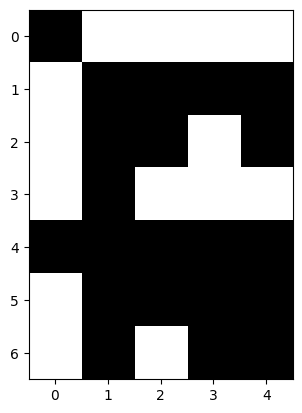

In [208]:
N_disortions = 5

# Get random letter
test_idx = random.randint(0,25)

# Add distortions
test_distort = distort_img(clean_letters[test_idx],N_disortions)

# Show letter
show_letter(test_distort)

Keep the M_repetitions to a maximum of 100. It takes long to simulate the data. 50 repetitions is just right.

In [209]:
###############################################
# Variations and testing
###############################################

def create_test_set(clean_letters, M, N):

  labels = ['a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z']

  # Initialize empty lists
  test_data = []
  test_answers = []

  for i in range(len(clean_letters)):
    for j in range(M):
      test_data.append(distort_img(clean_letters[i],N))
      test_answers.append(labels[i])

  return test_data, test_answers

In [220]:
###############################################
# Testing out distortions
###############################################

# Tunable parameters
N_distortions = 1
M_repetitions = 100
display_log   = False

# First create the test data
test_data, test_answers = create_test_set(clean_letters, M_repetitions ,N_distortions)

# Test using our model earlier
test_model(test_data,test_answers,letter_im,letter_am,D,display_log)

Final accuracy is: 99.269231
{'a': 1.0, 'b': 1.0, 'c': 1.0, 'd': 0.97, 'e': 1.0, 'f': 1.0, 'g': 0.97, 'h': 1.0, 'i': 1.0, 'j': 1.0, 'k': 1.0, 'l': 1.0, 'm': 0.98, 'n': 0.97, 'o': 0.92, 'p': 1.0, 'q': 1.0, 'r': 1.0, 's': 1.0, 't': 1.0, 'u': 1.0, 'v': 1.0, 'w': 1.0, 'x': 1.0, 'y': 1.0, 'z': 1.0}
